In [12]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, MNIST
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import os

DEVICE = torch.device('cuda')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [13]:
def switch_to_device(dataset,device=None):
    final_X, final_Y = [], []
    for x, y in dataset:
        final_X.append(x)
        final_Y.append(y)
    X = torch.stack(final_X)
    Y = torch.tensor(final_Y)
    if device is not None:
        X = X.to(device)
        Y = Y.to(device)
    return TensorDataset(X, Y)

In [14]:
def get_Cifar10_dl(batch_size_train=256, batch_size_eval=1024, device=DEVICE):
    transform = transforms.Compose([transforms.ToTensor()])
    
    data_train = CIFAR10('./datasets', train=True, download=True, transform=transform)
    data_train = switch_to_device(data_train, device=device)
    data_train, data_valid = torch.utils.data.random_split(data_train, [45000,5000])
    
    data_test = CIFAR10('./datasets', train=False, download=True, transform=transform)
    data_test = switch_to_device(data_test, device=device)
    
    train_dl = DataLoader(data_train, batch_size=batch_size_train, shuffle=True)
    valid_dl = DataLoader(data_valid, batch_size=batch_size_eval, shuffle=False)
    test_dl = DataLoader(data_test, batch_size=batch_size_eval, shuffle=False)
    
    return train_dl, valid_dl, test_dl

In [15]:
def get_mnist_dl(batch_size_train=1024, batch_size_eval=1024, device=torch.device('cuda')):
    transform = transforms.Compose([transforms.ToTensor()])
    
    data_train = MNIST('./datasets', train=True, download=True, transform=transform)
    data_train = switch_to_device(data_train, device=device)
    data_train, data_valid = torch.utils.data.random_split(data_train, [55000,5000])
    
    data_test = MNIST('./datasets', train=False, download=True, transform=transform)
    data_test = switch_to_device(data_test, device=device)
    
    train_dl = DataLoader(data_train, batch_size=batch_size_train, shuffle=True)
    valid_dl = DataLoader(data_valid, batch_size=batch_size_eval, shuffle=False)
    test_dl = DataLoader(data_test, batch_size=batch_size_eval, shuffle=False)
    
    return train_dl, valid_dl, test_dl

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
@torch.no_grad()
def get_acc(model, dl):
  model.eval()
  acc = []
  for X, y in dl:
    #acc.append((torch.sigmoid(model(X)) > 0.5) == y)
    acc.append(torch.argmax(model(X), dim=1) == y)
  acc = torch.cat(acc)
  acc = torch.sum(acc)/len(acc)
  model.train()
  return acc.item()

In [18]:
def print_stats(stats):

  fig, axs= plt.subplots(2, 2, figsize=(7,7), dpi=110)

  axs[0, 0].set_title("ERM loss")
  axs[0, 1].set_title("Valid Acc")
  axs[1, 0].set_title("mean")
  axs[1, 1].set_title("median")



  for i in range(2):
    for j in range(2):
      axs[i, j].set_xlabel("iterations")
      axs[i, j].grid()
  
  itrs = [x[0] for x in stats['train-loss']]
  loss = [x[1] for x in stats['train-loss']]
  axs[0, 0].set_ylim(0.0, max(loss))
  axs[0, 0].plot(itrs, loss)

  itrs = [x[0] for x in stats['valid-acc']]
  acc = [x[1] for x in stats['valid-acc']]
  axs[0, 1].set_ylim(0.0, 1.05)
  axs[0, 1].plot(itrs, acc)

  itrs = [x[0] for x in stats['mean']]
  diff_mean = [x[1].cpu() for x in stats['mean']]
  axs[1, 0].set_ylim(min(diff_mean), max(diff_mean))
  axs[1, 0].scatter(itrs, diff_mean)
  z = np.polyfit(itrs, diff_mean, 1)
  p = np.poly1d(z)
  axs[1, 0].plot(itrs, p(itrs))

  itrs = [x[0] for x in stats['median']]
  diff_variance = [x[1].cpu() for x in stats['median']]
  axs[1, 1].set_ylim(min(diff_variance), max(diff_variance))
  axs[1, 1].scatter(itrs, diff_variance)
  z = np.polyfit(itrs, diff_variance, 1)
  p = np.poly1d(z)
  axs[1, 1].plot(itrs, p(itrs))

  plt.tight_layout()
  fig.savefig('testing.jpg', bbox_inches = 'tight')

In [19]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.fc = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(4*4*512, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU())
        self.fc3= nn.Sequential(
            nn.Linear(1024, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)

        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [20]:
class Batch_CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(Batch_CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Hardtanh())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.Hardtanh(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Hardtanh())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.Hardtanh(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(7*7*128, 1024),
            nn.BatchNorm1d(1024),
            nn.Hardtanh())
        self.fc1 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Hardtanh())
        self.fc2 = nn.Sequential(
            #nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.Hardtanh())
        self.fc4= nn.Sequential(
            nn.Linear(1024, num_classes))
    
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc4(out)
        return out

In [21]:
def run_experiment(model, opt, scheduler, criterion, train_dl, valid_dl, test_dl, max_epochs, print_corrcoef, itr_gap, target_layer):
    itr = -1
    stats = {'train-loss' : [], 'valid-acc' : [], 'mean' : [], 'median' : []}

    for epoch in range(max_epochs):
        for x, y in train_dl:
            itr += 1
            opt.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            if print_corrcoef:
                if itr%itr_gap == 0:
                    cur_layer = -1
                    for i, (name, parameters) in enumerate(model.named_parameters()):
                        if len(parameters.shape) == 2:
                                cur_layer += 1
                                if cur_layer == target_layer:
                                    g = parameters.grad
                                    a = torch.corrcoef(g)
                                    stats['mean'].append((itr, torch.mean(torch.abs(a))))
                                    stats['median'].append((itr, torch.median(torch.abs(a))))
                                    #print(target_itr, torch.mean(torch.abs(a)), torch.median(torch.abs(a)))
                                    #return torch.mean(torch.abs(a)), torch.median(torch.abs(a))
                                    break
            
            opt.step()
            scheduler.step()
            stats['train-loss'].append((itr, loss.item()))

            if itr % 100 == 0:
                #print(same_sign_perc)
                valid_acc = get_acc(model, valid_dl)
                stats['valid-acc'].append((itr, valid_acc))
                if print_corrcoef:
                    s = f"{epoch}:{itr} [train] loss:{loss.item():.3f}, [valid] acc:{valid_acc:.3f}, mean: {torch.mean(torch.abs(a)):.3f}, median: {torch.median(torch.abs(a)):.3f}"
                else:
                    s = f"{epoch}:{itr} [train] loss:{loss.item():.3f}, [valid] acc:{valid_acc:.3f}"
                print(s)

    test_acc = get_acc(model, test_dl)
    print(f"[test] acc:{test_acc:.3f}")

    return stats    
                                    



In [22]:
model= VGG16().to(DEVICE)
#model = Batch_CNN().to(DEVICE)
#model = CNN().to(DEVICE)
#model = small_CNN().to(DEVICE)
#model = LeNet().to(DEVICE)
print(count_parameters(model))

train_batch_size = 256
test_batch_size = 1024

#train_dl, valid_dl, test_dl = get_mnist_dl(train_batch_size, test_batch_size, device = DEVICE)
train_dl, valid_dl, test_dl = get_Cifar10_dl(train_batch_size, test_batch_size, device = DEVICE)

#opt = torch.optim.SGD(model.parameters(), lr = 1e-1)
opt = torch.optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=2000, gamma=0.5)
criterion =nn.CrossEntropyLoss()
max_epochs = 20

print_corrcoef = True
itr_gap = 50
target_layer = 2

13424202
Files already downloaded and verified
Files already downloaded and verified


0:0 [train] loss:2.355, [valid] acc:0.103, mean: 0.191, median: 0.167
0:100 [train] loss:1.121, [valid] acc:0.546, mean: 0.270, median: 0.233
1:200 [train] loss:0.835, [valid] acc:0.637, mean: 0.279, median: 0.244
1:300 [train] loss:0.806, [valid] acc:0.695, mean: 0.288, median: 0.250
2:400 [train] loss:0.591, [valid] acc:0.717, mean: 0.295, median: 0.260
2:500 [train] loss:0.543, [valid] acc:0.757, mean: 0.260, median: 0.228
3:600 [train] loss:0.431, [valid] acc:0.783, mean: 0.277, median: 0.241
3:700 [train] loss:0.451, [valid] acc:0.785, mean: 0.267, median: 0.233
4:800 [train] loss:0.345, [valid] acc:0.751, mean: 0.271, median: 0.235
5:900 [train] loss:0.282, [valid] acc:0.760, mean: 0.283, median: 0.248
5:1000 [train] loss:0.325, [valid] acc:0.766, mean: 0.289, median: 0.253
6:1100 [train] loss:0.178, [valid] acc:0.765, mean: 0.325, median: 0.283
6:1200 [train] loss:0.350, [valid] acc:0.818, mean: 0.284, median: 0.250
7:1300 [train] loss:0.151, [valid] acc:0.793, mean: 0.295, medi

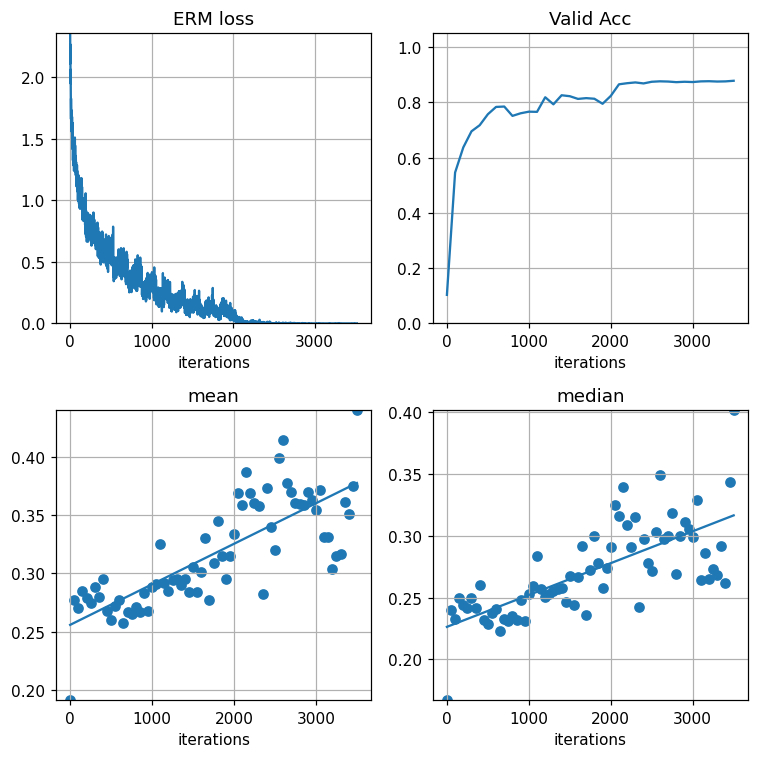

In [23]:
stats = run_experiment(model, opt, scheduler, criterion, train_dl, valid_dl, test_dl, max_epochs, print_corrcoef, itr_gap, target_layer)
print_stats(stats)